<a href="https://colab.research.google.com/github/neillinehan/NeilLinehanPortfolio/blob/main/rolling_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import dependencies

In [ ]:
import re
import matplotlib.colors
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#plotting functions

plotting functions assume:

* The input data is in the form of a pandas DataFrame.
* The two variables are numeric and can be used to calculate a rolling correlation.
* The DataFrame has a datetime index that can be used for resampling and calculating the rolling correlation.
* The function also assumes that the user has specified valid values for the win_len and resample_len arguments, which are used to calculate the rolling correlation and resample the data, respectively. These arguments must be valid offset strings that can be interpreted by pandas. See here: [Offset aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

In [ ]:
def reclassify_coor_df_vectorized(values,colors):
    """
    Vectorized version of the reclassify_coor_df function.
    """
    # Create an array of the same shape as values filled with the default color
    result = np.full(values.shape, '#ffffff')

    # Reclassify the values based on their range
    result[values < -0.6] = colors[0]
    result[(values >= -0.6) & (values < -0.2)] = colors[1]
    result[(values >= -0.2) & (values < 0.2)] = colors[2]
    result[(values >= 0.2) & (values < 0.6)] = colors[3]

    return result

In [ ]:
def plot_rolling_corr(df, var1, var2, win_len, resample_len,units=None, save_fig=None):
    """
    Plot the rolling correlation between two variables in a dataframe.

    Args:
        df (pd.DataFrame): The input dataframe containing the two variables to plot.
        var1 (str): The name of the first variable to plot.
        var2 (str): The name of the second variable to plot.
        win_len (str): The window length for calculating the rolling correlation. Offset string.
        resample_len (str): The resampling frequency for calculating the 95th percentile. Offset string.
        units (list of str): user specified units to plot, first element for left axis and var1, second element for right axis and var2
        save_fig (str, optional): The file path to save the figure. If None, the figure is not saved. Defaults to None.
    """
    # Calculate the rolling correlation between the two variables
    corr_df = df[var1].rolling(window=win_len, center=True).corr(df[var2])

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(11, 5))

    # Extract the variable names and units
    try:
        var1_name, var1_units = re.split(r'(?=[[])', var1)
    except:
        var1_name = var1
        var1_units = var1
    try:
        var2_name, var2_units = re.split(r'(?=[[])', var2)
    except:
        var2_name = var2
        var2_units = var2
    if units is not None:
      var1_units = units[0]
      var2_units = units[1]

    # Set the title of the plot
    ax.set_title(var1_name.replace("_", " ") + ' vs. ' + var2_name.replace("_", " ") + ' (' + resample_len + ' 95 percentile)')

    # Resample the dataframe and calculate the 95th percentile
    resampled_df = df[[var1, var2]].resample(resample_len).quantile(.95)

    # Plot the first line chart
    resampled_df[var1].plot(
        legend=False,
        ylabel=var1_units,
        ax=ax,
        c='#540360')

    # Plot the second line chart on the secondary y-axis
    resampled_df[var2].plot(
        c='#0F6003',
        legend=False,
        mark_right=True,
        ylabel=var2_units,
        secondary_y=True,
        ax=ax)

    # Define the colors for each interval
    colors = ['#ca0020', '#f4a582', '#f7f7f7', '#92c5de', '#0571b0'][::-1]

    # Create a custom colormap from the list of colors
    cmap = matplotlib.colors.ListedColormap(colors)

    # Reclassify the correlation values into different color categories
    coor_colors = reclassify_coor_df_vectorized(corr_df.values,colors)

    # Fill the area between the line and the x-axis with different colors based on the correlation values
    max_value = resampled_df.max().max()

    print("Filling in correlation background...")

    for color in colors:
      start_time = time.time()
      boolean_series = (coor_colors == color)

      # Use numpy's roll function to shift the array by one element
      shifted_series = np.roll(boolean_series, 1)

      # Replace the first element with False
      shifted_series[0] = False

      ax.fill_between(x=corr_df.index,
                    y1=0,
                    y2=max_value,
                    where=(boolean_series | shifted_series),
                    facecolor=color,
                    step='post',
                    alpha=.5)
      print(color + " time Taken: %s s" % (time.time() - start_time))

    # Add a colorbar to the plot
    bounds = [-1, -0.6, -0.2, 0.2, 0.6, 1]

    norm = plt.Normalize(vmin=-1, vmax=1)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm,)

    sm.set_array([])

    cbar = plt.colorbar(sm, boundaries=bounds, ticks=bounds, ax=plt.gca())

    cbar.set_label(win_len + ' Rolling Correlation')

    cbar.ax.set_position([0.9, 0.15, 0.05, 0.7])

    cbar.set_alpha(.5)

    cbar.draw_all()

    # Adjust the spacing of the plot
    lines = ax.get_lines() + ax.right_ax.get_lines()

    ax.legend(lines, [
                   var1_name.replace("_", " "),
                   var2_name.replace("_", " ")
                   ],
               loc='upper left')

    if save_fig is not None:
      fig.savefig('rolling_corr_' + win_len + '-' + var1_name + '_' + var2_name + '_' + resample_len + '.png')


#Flox demo case

In [ ]:
filename = '/content/ALL_INDEX_FLOX_2023-08-15_15_21_50.csv' #FloX GUI processed data

##Cleaning up data to fit function assumptions

In [ ]:
# Read the CSV file specified by the filename variable, using a semicolon as the separator between columns
# Any cells containing the value #N/D are treated as missing values and replaced with NaN
SIF_df = pd.read_csv(filename, sep = ';', na_values=[r'#N/D'])

# Convert the 'datetime [UTC]' column of the resulting DataFrame to a pandas DatetimeIndex with UTC timezone information
SIF_df['datetime [UTC]'] = pd.to_datetime(SIF_df['datetime [UTC]'], utc=True)

# Add a time offset to the 'datetime [UTC]' column based on the cumulative count of rows within each group defined by the 'datetime [UTC]' column
# This means that if there are multiple rows with the same 'datetime [UTC]' value, each subsequent row will have its 'datetime [UTC]' value incremented by one minute
SIF_df['datetime [UTC]'] += pd.to_timedelta(SIF_df.groupby('datetime [UTC]').cumcount(), unit='m')

# Set the index of the DataFrame to be the 'datetime [UTC]' column, converted from UTC to US/Central timezone
# The index is then given the name 'datetime'
SIF_df.index = SIF_df['datetime [UTC]'].dt.tz_convert('US/Central') #convert UTC to local
SIF_df.index.name = 'datetime'

# Sort the DataFrame by its index and select only rows with an index value between '2023-05-14' and '2023'
# This effectively filters the DataFrame to only include rows within a specific date range
SIF_df = SIF_df.sort_index().loc['2023-05-14': '2023'] #set the date range of interest, getting rid of 8 rows


##Inspect avaiable variables

In [ ]:
SIF_df.columns

Index(['doy.dayfract', 'datetime [UTC]', 'SZA', 'Lat', 'Lon', 'temp1 [C]',
       'temp2 [C]', 'temp3 [C]', 'temp4 [C]', 'h1 [%]', 'h2 [%]',
       'Incoming at 750nm [W m-2nm-1sr-1]', 'Reflected 750 [W m-2nm-1sr-1]',
       'Reflected 760 [W m-2nm-1sr-1]', 'Reflected 687 [W m-2nm-1sr-1]',
       'Reflectance 750 [-]', 'Reflectance 760 [-]', 'E_stability [%]',
       'sat value L', 'sat value E', 'sat value E2', 'Dynamic range E [%]',
       'Dynamic range L [%]', 'SIF_A_ifld [mW m-2nm-1sr-1]',
       'SIF_B_ifld [mW m-2nm-1sr-1]', 'SIF_A_sfm [mW m-2nm-1sr-1]',
       'SIF_B_sfm [mW m-2nm-1sr-1]', 'A_sfm_conv', 'B_sfm_conv',
       'Incoming at 750nm Full [W m-2nm-1sr-1]',
       'Reflected 750nm full [W m-2nm-1sr-1]', 'PAR inc [W m-2]',
       'PAR ref [W m-2]', 'APAR [umol m-2 s-1]', 'E_stability full [%]',
       'sat value L full', 'sat value E full', 'sat value E2 full',
       'Dynamic range E full [%]', 'Dynamic range L full [%]', 'SSHIFT [nm]',
       'NDVI', 'PRI', 'MTCI', 'SR

##Call plotting function


Filling in correlation background...
#0571b0 time Taken: 4.86144232749939 s
#92c5de time Taken: 5.723957538604736 s
#f7f7f7 time Taken: 4.6500084400177 s
#f4a582 time Taken: 5.961389780044556 s
#ca0020 time Taken: 4.986072063446045 s


<ipython-input-21-44d5769abcf6>:107: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


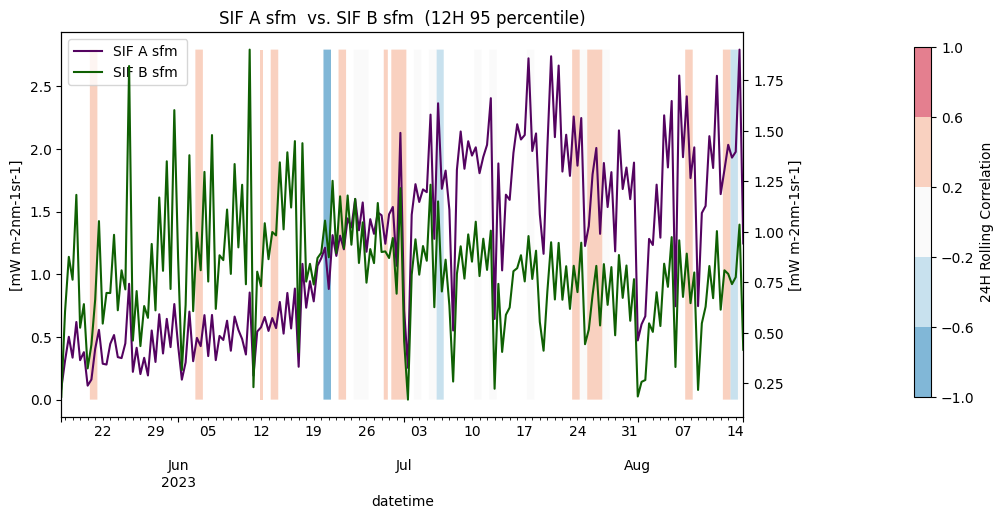

In [ ]:
plot_rolling_corr(df=SIF_df,
                  var1='SIF_A_sfm [mW m-2nm-1sr-1]',
                  var2='SIF_B_sfm [mW m-2nm-1sr-1]',
                  win_len='24H',
                  resample_len='12H',
                  save_fig=False)